In [1]:
import os
import pickle

import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from fastai.tabular.all import *

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay

In [2]:
files = ['sklearn-RFC-CV-FS-RFE-RFC.pkl', 'sklearn-XGB-CV-FS-RFE-XGB.pkl' , 'sklearn-XGB-CV-NFS.pkl', 'fastai-CE-ES.pkl', 'fastai-FL-ES.pkl'] # 'fastai-FL-NES.pkl']

In [23]:
model_name_map = {
    'sklearn-RFC-CV-FS-RFE-RFC': 'Random Forrest', 
    'sklearn-XGB-CV-FS-RFE-XGB': 'XGBoost w/ Feature Selection',
    'sklearn-XGB-CV-NFS': 'XGBoost w/o Feature Selection (BEST MODEL)',
    'fastai-CE-ES': 'NN Cross-Entropy Loss w/ Early Stopping',
    'fastai-FL-ES': 'NN Focal Loss w/ Early Stopping',
    'fastai-FL-NES': 'NN Focal Loss  w/o Early Stopping'
}

In [4]:
data = {}

for file in files:
    with open(f'./predictions/{file}', 'rb+') as f:
        model_name = file.split('.')[0]
        data[model_name] = pickle.load(f)

In [5]:
data.keys()

dict_keys(['sklearn-RFC-CV-FS-RFE-RFC', 'sklearn-XGB-CV-FS-RFE-XGB', 'sklearn-XGB-CV-NFS', 'fastai-CE-ES', 'fastai-FL-ES'])

In [6]:
list(data.values())[0]

{'model': 'fastai',
 'validation_set_predicted_probs': array([0.08718028, 0.04113704, 0.03784771, ..., 0.10746397, 0.27394795,
        0.84160712]),
 'validation_set_predicted_labels': array([0, 0, 0, ..., 0, 0, 1]),
 'validation_set_actual_labels': 230628    0
 230629    0
 230630    0
 230631    0
 230632    0
          ..
 311101    0
 311102    0
 311103    0
 311104    0
 311105    1
 Name: Goal, Length: 80478, dtype: int64}

In [7]:
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

def compute_cumulative_goal_rate_per_percentile(probs, y):
        percentiles = []
        rates = []
        cum_rate = 0

        for i in range(0, 101):
            percentile = np.percentile(probs, i)
            goals = 0
            no_goals = 0
            for idx, p in enumerate(probs):
                if p<=percentile:
                    if y[idx]==1:
                        goals+=1
                    else:
                        no_goals+=1
            cum_rate += goals / (goals + no_goals)
            percentiles.append(percentile)
            rates.append(cum_rate)
        return percentiles, rates

In [8]:
path = '../data/M2Data'
df = pd.read_csv(f'{path}/traningSetFastAI.csv')

# Train / Valid Split
season_split = 2018
train_ix, valid_ix = df[df.season < season_split].index, df[df.season >= season_split].index

X, y = df.drop(labels='Goal', axis=1), df['Goal']
train_df, valid_df = df.iloc[train_ix], df.iloc[valid_ix]
X_train, X_val, y_train, y_val = X.iloc[train_ix], X.iloc[valid_ix], y.iloc[train_ix], y.iloc[valid_ix]

random_clf = DummyClassifier(strategy="uniform").fit(X_train, y_train)
random_probs = random_clf.predict_proba(X_val)[:, 1]

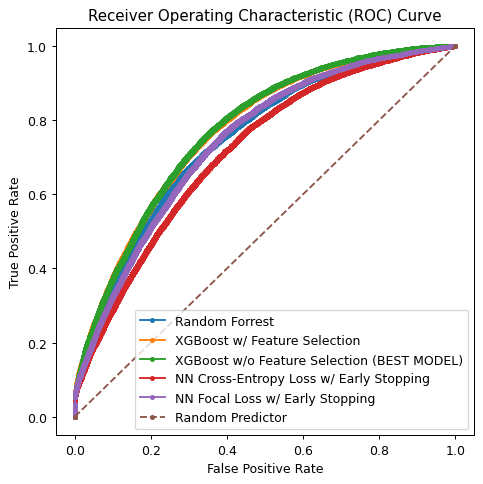

In [24]:
plt.figure(figsize=(6, 6), dpi=90)
for model in data.keys():
    y_val, val_y_pred_proba = data[model]['validation_set_actual_labels'], data[model]['validation_set_predicted_probs']
    xgb_fpr, xgb_tpr, _ = roc_curve(y_val, val_y_pred_proba)
    plt.plot(xgb_fpr, xgb_tpr, marker='.', label=f'{model_name_map[model]}')
plt.plot([0, 1], [0, 1], linestyle='--', marker='.', label='Random Predictor')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('../figures/q6-roc.png')
plt.show()

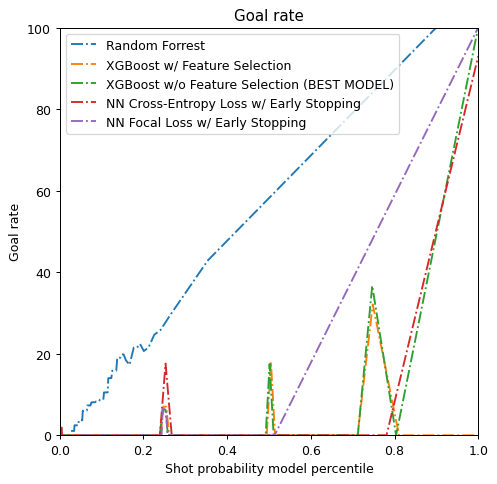

In [27]:
### goal_rate = F(shot probability model percentile) ###
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        r_percentile = round(percentile, 2)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
#             if p<=percentile:
            if round(p, 2)==r_percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals *100 / (goals + no_goals) if goals + no_goals != 0 else 0
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

plt.figure(figsize=(6, 6), dpi=90)
for model in data.keys():
    y_val, val_y_pred_proba = data[model]['validation_set_actual_labels'], data[model]['validation_set_predicted_probs']
    percentiles1, rates1 = compute_goal_rate_per_percentile(val_y_pred_proba, np.array(y_val))
    plt.plot(percentiles1, rates1, linestyle='-.', label=f'{model_name_map[model]}')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()
plt.ylim([0, 100])
plt.xlim([0, 1])
plt.title('Goal rate')

plt.savefig('../figures/6-goal_rate_percentile_1.png')

plt.show()


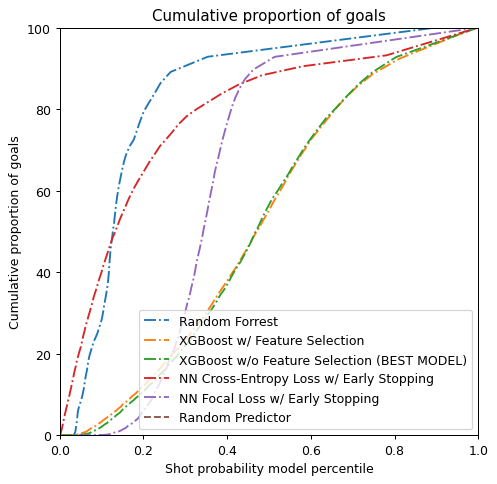

In [26]:
### cumulative portion of goals = F(shot probability model percentile) ###
def compute_cumulative_propotion_of_goals_per_percentile(probs, y):
    percentiles = []
    cum_rates = []
    cum_rate = 0
    total_goals = sum(y)
    cum_goals = 0
    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        cum_goals=0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    cum_goals+=1 
        cum_rate = cum_goals * 100 / total_goals
        percentiles.append(percentile)
        cum_rates.append(cum_rate)
    return percentiles, cum_rates

plt.figure(figsize=(6, 6), dpi=90)
for model in data.keys():
    y_val, val_y_pred_proba = data[model]['validation_set_actual_labels'], data[model]['validation_set_predicted_probs']
    percentiles1, rates1 = compute_cumulative_propotion_of_goals_per_percentile(val_y_pred_proba, np.array(y_val))
    plt.plot(percentiles1, rates1, linestyle='-.', label=f'{model_name_map[model]}')

percentiles4, rates4 = compute_cumulative_propotion_of_goals_per_percentile(random_probs, y_val)
plt.plot(percentiles4, rates4, linestyle='--', label='Random Predictor')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative proportion of goals')
plt.legend(loc='lower right')
plt.ylim([0, 100])
plt.xlim([0, 1])
plt.title('Cumulative proportion of goals')

plt.savefig('../figures/q6-goal_rate_percentile_2.png')

plt.show()


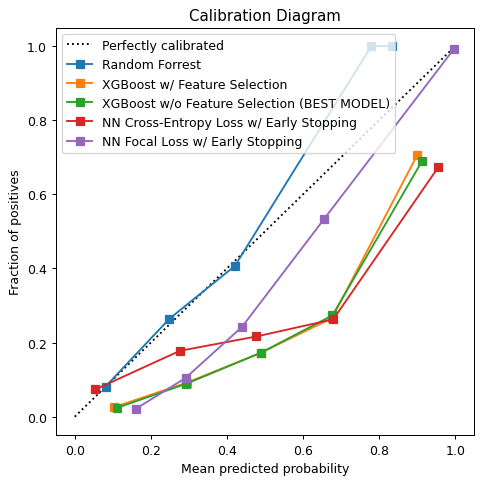

In [25]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=90)
for model in data.keys():
    y_val, val_y_pred_proba = data[model]['validation_set_actual_labels'], data[model]['validation_set_predicted_probs']
    disp1 = CalibrationDisplay.from_predictions(y_val, val_y_pred_proba, label=f'{model_name_map[model]}', ax=ax)

ax.legend(loc='upper left')
plt.title('Calibration Diagram')
plt.savefig('../figures/6-calibration_diagram.png')
plt.show()

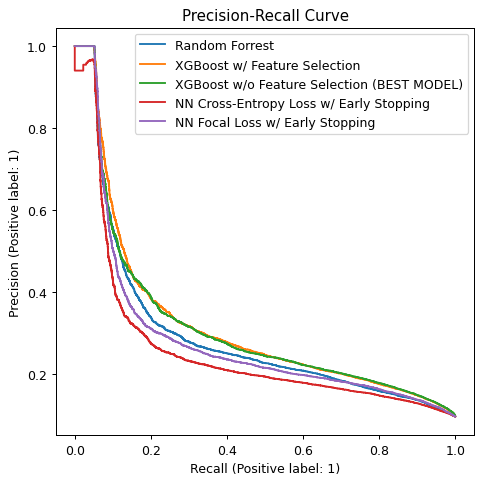

In [28]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=90)
for model in data.keys():
    y_val, val_y_pred_proba = data[model]['validation_set_actual_labels'], data[model]['validation_set_predicted_probs']
    disp1 = PrecisionRecallDisplay.from_predictions(y_val, val_y_pred_proba, pos_label=1, label=f'{model_name_map[model]}', ax=ax)

ax.legend(loc='upper right')
plt.title('Precision-Recall Curve')
plt.savefig('../figures/6-precision_recall_curve.png')
plt.show()